# Reducing Image Classification Noise

In [1]:
import numpy as np 
import pandas as pd
import h5py
import cv2
import math
import os

import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model, Model
from keras.layers import Input, UpSampling2D
from keras.layers.advanced_activations import PReLU, LeakyReLU
from keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from keras.layers import Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

Using TensorFlow backend.


### Load Data and Preprocess

In [2]:
data = pd.read_csv("data/letters.csv")
files = data['file']
letters = data['letter']
backgrounds = data['background']

In [3]:
f = h5py.File('data/LetterColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['backgrounds', 'images', 'labels']

In [4]:
backgrounds = np.array(f[keys[0]])
tensors = np.array(f[keys[1]])
targets = np.array(f[keys[2]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)
print ('Background shape:', backgrounds.shape)

Tensor shape: (1650, 32, 32, 3)
Target shape (1650,)
Background shape: (1650,)


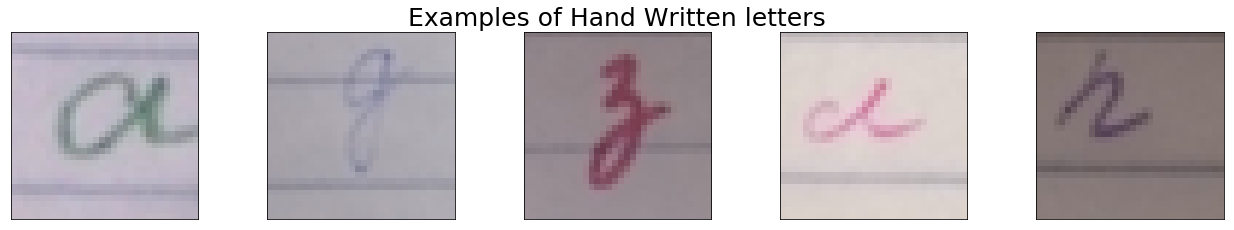

In [5]:
fig, ax = plt.subplots(figsize=(18, 3), nrows=1, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(5):
    image = tensors[i*200]/255
    ax[i].imshow(image)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[2].set_title('Examples of Hand Written letters', fontsize=25);

In [6]:
tensors = tensors.astype('float32')/255

In [7]:
gray_tensors = np.dot(tensors[...,:3], [0.299, 0.587, 0.114])
gray_tensors = gray_tensors.reshape(-1, 32, 32, 1)
print ('Grayscaled Tensor shape:', gray_tensors.shape)

Grayscaled Tensor shape: (1650, 32, 32, 1)


In [8]:
cat_targets = to_categorical(np.array(targets-1), 33)
cat_targets.shape

(1650, 33)

In [9]:
backgrounds = to_categorical(backgrounds,2)
backgrounds.shape

(1650, 2)

In [10]:
back_targets = np.concatenate((cat_targets, backgrounds), axis=1)
back_targets.shape

(1650, 35)

### Create and Train Model

In [11]:
x_train, x_test, y_train, y_test = train_test_split(gray_tensors, cat_targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)

n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [12]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(gray_tensors, back_targets, 
                                                        test_size = 0.2, 
                                                        random_state = 1)
n = int(len(x_test2)/2)
x_valid2, y_valid2 = x_test2[:n], y_test2[:n]
x_test2, y_test2 = x_test2[n:], y_test2[n:]

In [13]:
def autoencoder():
    inputs = Input(shape=(32, 32, 1))
    
    # Encode
    x = Conv2D(32, 5, padding='same')(inputs)
    x = LeakyReLU(alpha=0.02)(x)
    x = MaxPooling2D(padding='same')(x)
    x = Conv2D(8, 5, padding='same')(x)
    x = LeakyReLU(alpha=0.02)(x)
    encoded = MaxPooling2D(padding='same')(x)  
    
    #Decode
    x = Conv2D(8, 5, padding='same')(encoded)
    x = LeakyReLU(alpha=0.02)(x)
    x = UpSampling2D()(x)
    x = Conv2D(32, 5, padding='same')(x) 
    x = LeakyReLU(alpha=0.02)(x)
    x = UpSampling2D()(x)
    
    decoded = Conv2D(1, 3, activation='sigmoid', padding='same')(x)
    
    # Autoencoder
    autoencoder = Model(inputs, decoded)
    
    # Compile
    autoencoder.compile(optimizer='nadam', loss='binary_crossentropy')
    
    return autoencoder



autoencoder = autoencoder()
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        832       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 8)         6408      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 8)         0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 8)           0         
__________

In [15]:
autoencoder_history = autoencoder.fit(x_train, x_train, 
                                      epochs=200, batch_size=62, verbose=2,
                                      validation_data=(x_valid, x_valid))

Train on 1320 samples, validate on 165 samples
Epoch 1/200
 - 6s - loss: 0.6649 - val_loss: 0.6667
Epoch 2/200
 - 9s - loss: 0.6635 - val_loss: 0.6682
Epoch 3/200
 - 7s - loss: 0.6572 - val_loss: 0.6453
Epoch 4/200
 - 6s - loss: 0.6519 - val_loss: 0.6397
Epoch 5/200
 - 6s - loss: 0.6514 - val_loss: 0.6404
Epoch 6/200
 - 8s - loss: 0.6500 - val_loss: 0.6391
Epoch 7/200
 - 7s - loss: 0.6460 - val_loss: 0.6405
Epoch 8/200
 - 7s - loss: 0.6446 - val_loss: 0.6461
Epoch 9/200
 - 7s - loss: 0.6460 - val_loss: 0.6387
Epoch 10/200
 - 6s - loss: 0.6433 - val_loss: 0.6422
Epoch 11/200
 - 7s - loss: 0.6443 - val_loss: 0.6384
Epoch 12/200
 - 7s - loss: 0.6431 - val_loss: 0.6382
Epoch 13/200
 - 8s - loss: 0.6422 - val_loss: 0.6474
Epoch 14/200
 - 7s - loss: 0.6421 - val_loss: 0.6356
Epoch 15/200
 - 6s - loss: 0.6399 - val_loss: 0.6333
Epoch 16/200
 - 6s - loss: 0.6395 - val_loss: 0.6350
Epoch 17/200
 - 7s - loss: 0.6409 - val_loss: 0.6332
Epoch 18/200
 - 7s - loss: 0.6395 - val_loss: 0.6333
Epoch 19

Epoch 154/200
 - 6s - loss: 0.6360 - val_loss: 0.6309
Epoch 155/200
 - 7s - loss: 0.6353 - val_loss: 0.6309
Epoch 156/200
 - 8s - loss: 0.6352 - val_loss: 0.6315
Epoch 157/200
 - 6s - loss: 0.6357 - val_loss: 0.6315
Epoch 158/200
 - 6s - loss: 0.6352 - val_loss: 0.6310
Epoch 159/200
 - 8s - loss: 0.6354 - val_loss: 0.6312
Epoch 160/200
 - 6s - loss: 0.6352 - val_loss: 0.6309
Epoch 161/200
 - 6s - loss: 0.6351 - val_loss: 0.6314
Epoch 162/200
 - 6s - loss: 0.6360 - val_loss: 0.6310
Epoch 163/200
 - 6s - loss: 0.6354 - val_loss: 0.6308
Epoch 164/200
 - 6s - loss: 0.6351 - val_loss: 0.6309
Epoch 165/200
 - 6s - loss: 0.6354 - val_loss: 0.6311
Epoch 166/200
 - 6s - loss: 0.6352 - val_loss: 0.6308
Epoch 167/200
 - 6s - loss: 0.6351 - val_loss: 0.6312
Epoch 168/200
 - 6s - loss: 0.6356 - val_loss: 0.6308
Epoch 169/200
 - 6s - loss: 0.6354 - val_loss: 0.6310
Epoch 170/200
 - 6s - loss: 0.6354 - val_loss: 0.6311
Epoch 171/200
 - 6s - loss: 0.6353 - val_loss: 0.6307
Epoch 172/200
 - 6s - loss: 

In [16]:
x_test_decoded = autoencoder.predict(x_test)

### Visualize Data

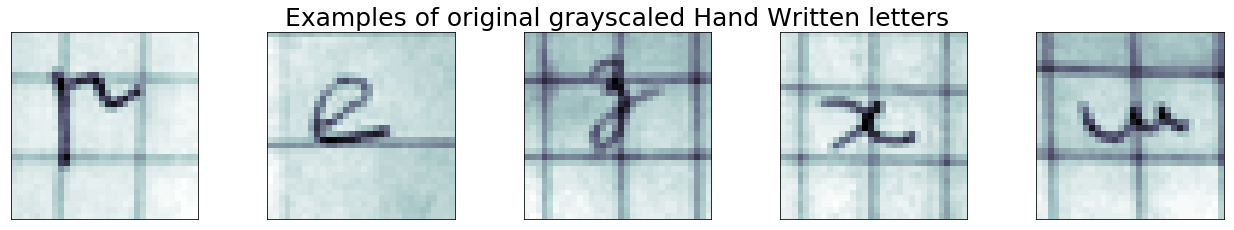

In [17]:
fig, ax = plt.subplots(figsize=(18, 3), nrows=1, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(5):
    image = x_test[i*10].reshape(32,32)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[2].set_title('Examples of original grayscaled Hand Written letters', fontsize=25);

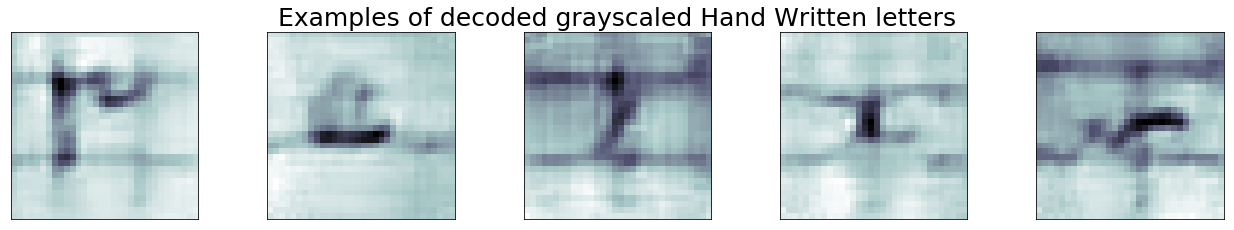

In [18]:
fig, ax = plt.subplots(figsize=(18, 3), nrows=1, ncols=5, sharex=True, sharey=True,)
ax = ax.flatten()
for i in range(5):
    image = x_test_decoded[i*10].reshape(32,32)
    ax[i].imshow(image, cmap=cm.bone)

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.gcf()
ax[2].set_title('Examples of decoded grayscaled Hand Written letters', fontsize=25);